In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

import pretty_confusion_matrix as pcm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import vanilla_vae

import igraph as ig
from sklearn.decomposition import TruncatedSVD
from anndata import AnnData

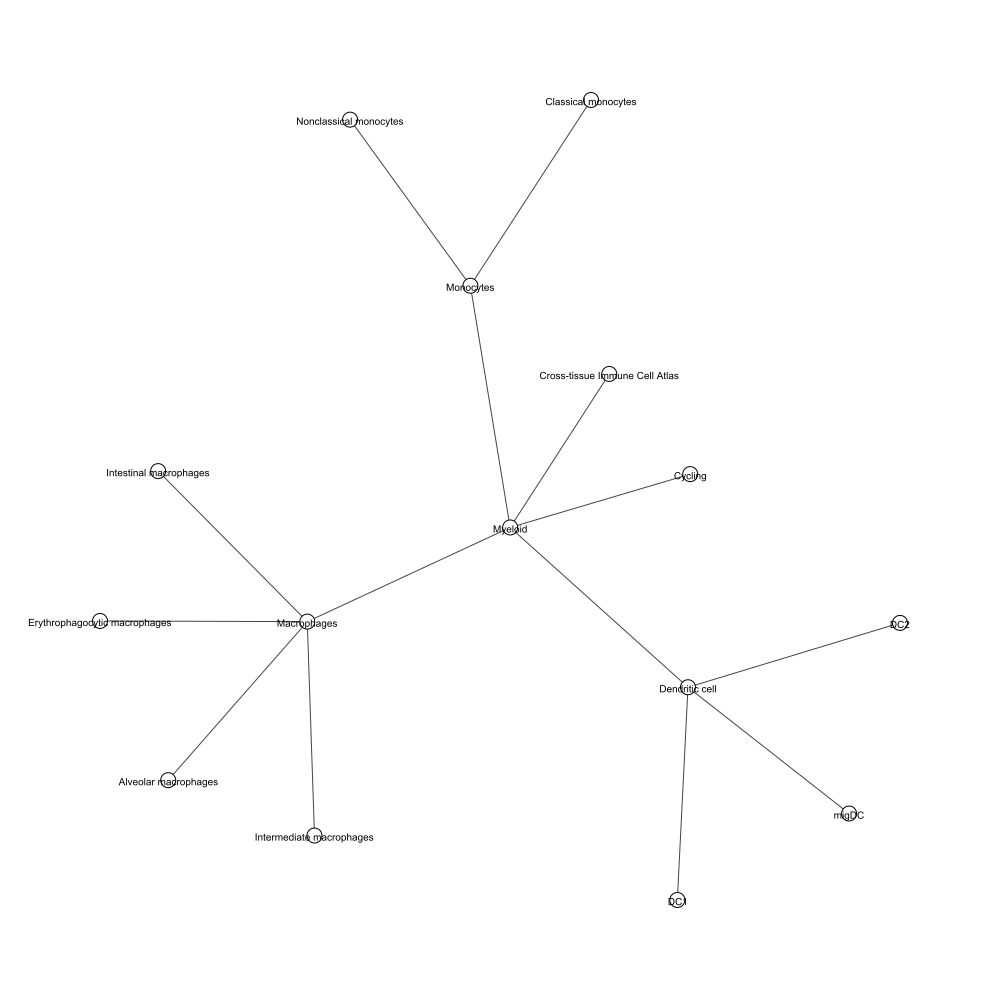

In [2]:
dataset = sc.read('myeloid.h5ad')

list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
list_filtered_celltypes = list(filter(lambda x: 'doublets' not in x, list_ct)) 
dataset = dataset[dataset.obs['Manually_curated_celltype'].isin(list_filtered_celltypes)]

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])

list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'Myeloid', 'Dendritic cell', 'Macrophages', 'Monocytes']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

def transfrom(x):
    if x in list_inner_nodes:
        return encoder_celltype_inner.transform([x])[0] + len(list_ct)
    else:
        return encoder_celltype.transform([x])[0]

encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}

g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = np.append(encoder_celltype.inverse_transform(list(range(len(list_ct)))), encoder_celltype_inner.inverse_transform(list(range(len(list_inner_nodes)))))
g.add_edges([(transfrom('Cross-tissue Immune Cell Atlas'), transfrom('Myeloid'))])
g.add_edges([(transfrom('Myeloid'), transfrom('Cycling')),
             (transfrom('Myeloid'), transfrom('Dendritic cell')),
             (transfrom('Myeloid'), transfrom('Macrophages')),
             (transfrom('Myeloid'), transfrom('Monocytes'))])
g.add_edges([(transfrom('Dendritic cell'), transfrom('DC1')),
             (transfrom('Dendritic cell'), transfrom('DC2')),
             (transfrom('Dendritic cell'), transfrom('migDC'))])
g.add_edges([(transfrom('Macrophages'), transfrom('Alveolar macrophages')),
             (transfrom('Macrophages'), transfrom('Erythrophagocytic macrophages')),
             (transfrom('Macrophages'), transfrom('Intermediate macrophages')),
             (transfrom('Macrophages'), transfrom('Intestinal macrophages'))])
g.add_edges([(transfrom('Monocytes'), transfrom('Classical monocytes')),
             (transfrom('Monocytes'), transfrom('Nonclassical monocytes'))])

# g.write('tree', format='gml')
layout = g.layout("kamada_kawai")
ig.plot(g, layout=layout, vertex_label=g.vs["name"], vertex_label_size=10, vertex_size=15, bbox=(1000, 1000), margin=100, vertex_color='white')

In [3]:
def get_shortest_dist(node_1, node_2, graph):
    return len(graph.get_shortest_paths(node_1, node_2)[0])-1

dist_df = pd.DataFrame(0, index=np.arange(len(list_num_ct)), columns=np.arange(len(list_num_ct)))
for i in range(len(list_num_ct)):
    for j in range(len(list_num_ct)):
        dist_df.iloc[i, j]=get_shortest_dist(i, j, g)

D = dist_df
D = torch.tensor(D.values, dtype=float)

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
dataloader_training = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=test_subsampler)

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
# Pytorch version of the 3 fully connected layers
class Net(nn.Module):
    def __init__(self, mode, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PL(nn.Module):
    def __init__(self, centers):
        super(PL, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        targets = torch.index_select(self.centers, 0, labels)
        dist = torch.norm(mapping - targets, dim=1)
        dist = torch.sum(dist)
        return dist/mapping.shape[0]

In [13]:
embedding_dim = 8

def train(mode, loss_mode, epochs=30, cuda=1):
    D_metric = D.cuda()
    if mode == 'Net':
        model = Net(mode, 128, 32, len(list_ct)).cuda()
    elif mode == 'Proto_Net':
        model = Net(mode, 128, 32, embedding_dim).cuda()
        model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                prototypes=None, embedding_dim=embedding_dim, device='cuda').cuda()
    elif mode == 'VAE':
        model_vae = vanilla_vae.VanillaVAE(128, embedding_dim, [64]).cuda()
        model = prototypical_network.LearntPrototypes(model_vae, n_prototypes= D.shape[0],
                prototypes=None, embedding_dim=8, device='cuda', mode=mode).cuda()
    criterion = nn.CrossEntropyLoss()
    delta = DistortionLoss(D_metric)
    opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)

        model.train()
        t0 = time.time()
        for batch in dataloader_training:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                out = model(x)
            elif mode == 'Proto_Net':
                out, embeddings = model(x)
            elif mode == 'VAE':
                out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            opt.zero_grad()
            xe_loss = criterion(out, y)
            loss = 2 * xe_loss
            if 'pl' in loss_mode:
                pl_loss = PL(centers = model.prototypes.data)
                pl_loss_ = pl_loss(embeddings, y)
                loss = loss + pl_loss_
            if 'disto' in loss_mode:
                disto_loss = delta(model.prototypes)
                loss = loss + disto_loss
            if 'vae' in loss_mode:
                vae_loss = model_vae.loss_function(x_hat, x, mean, log_var, decoder_mu,decoder_log_var, M_N=1)
                loss = loss + vae_loss['loss']/10
            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
        t1 = time.time()
        
        print('Train ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        t0 = time.time()
        for batch in dataloader_testing:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                with torch.no_grad():
                    out = model(x)
            elif mode == 'Proto_Net':
                with torch.no_grad():
                    out, embeddings = model(x)
            elif mode == 'VAE':
                with torch.no_grad():
                    out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            pred = out.detach()
            ER_meter.add(pred.cpu(),y)
        t1 = time.time()
        print('Test ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))
    return model

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(mode, model):
    y_test = dataset[test_indices].obs['Manually_curated_celltype']
    if mode == 'Net':
        y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
    elif mode == 'Proto_Net':
        y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
    elif mode == 'VAE':
        y_pred, y_embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_indices].X).cuda())
    y_pred = y_pred.detach().cpu().numpy()
    pred = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))
    cm=confusion_matrix(y_test, pred)
    # Normalise
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                        yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show(block=False)

In [7]:
# mode in ['Net', 'Proto_Net', 'VAE']
mode = ''
# loss_mode in ['pl', 'disto', 'vae']
loss_mode = ''

Epoch 1
Train ER 36.19, time 1.7s
Test ER 7.01, time 0.0s
Epoch 2
Train ER 4.73, time 0.3s
Test ER 4.08, time 0.0s
Epoch 3
Train ER 3.51, time 0.3s
Test ER 3.51, time 0.0s
Epoch 4
Train ER 3.15, time 0.2s
Test ER 3.36, time 0.0s
Epoch 5
Train ER 2.95, time 0.2s
Test ER 3.18, time 0.0s
Epoch 6
Train ER 2.86, time 0.3s
Test ER 3.13, time 0.0s
Epoch 7
Train ER 2.76, time 0.2s
Test ER 3.04, time 0.0s
Epoch 8
Train ER 2.64, time 0.3s
Test ER 3.04, time 0.0s
Epoch 9
Train ER 2.54, time 0.3s
Test ER 3.07, time 0.0s
Epoch 10
Train ER 2.49, time 0.4s
Test ER 2.99, time 0.0s
Epoch 11
Train ER 2.45, time 0.3s
Test ER 2.99, time 0.1s
Epoch 12
Train ER 2.36, time 0.3s
Test ER 3.03, time 0.0s
Epoch 13
Train ER 2.34, time 0.3s
Test ER 2.96, time 0.0s
Epoch 14
Train ER 2.24, time 0.4s
Test ER 3.00, time 0.0s
Epoch 15
Train ER 2.30, time 0.3s
Test ER 2.95, time 0.0s
Epoch 16
Train ER 2.21, time 0.4s
Test ER 2.99, time 0.0s
Epoch 17
Train ER 2.18, time 0.3s
Test ER 2.92, time 0.0s
Epoch 18
Train ER 2.18

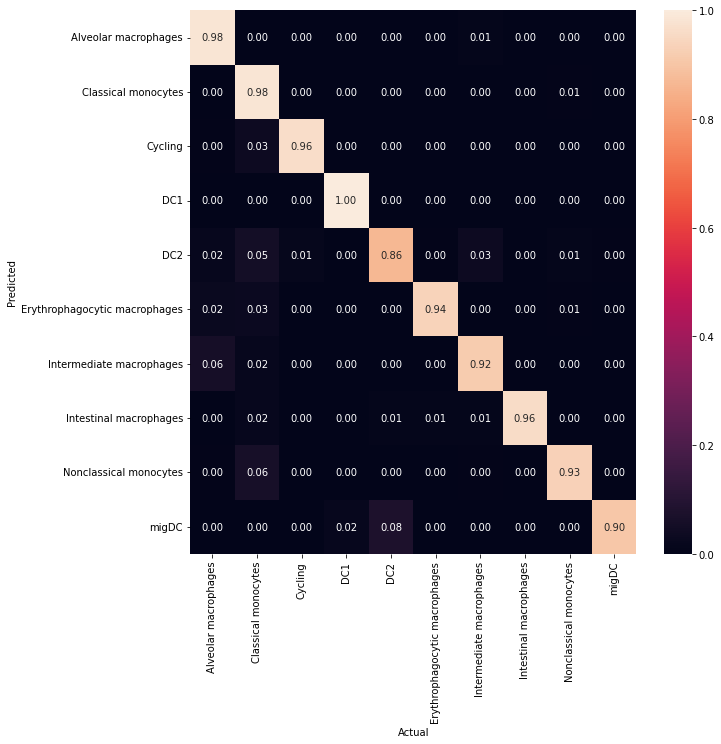

In [8]:
# Only Neural Network
mode = 'Net'
loss_mode = ''
model = train(mode=mode, loss_mode=loss_mode)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 44.81, time 0.7s
Test ER 10.11, time 0.1s
Epoch 2
Train ER 6.27, time 0.6s
Test ER 5.08, time 0.1s
Epoch 3
Train ER 5.01, time 0.6s
Test ER 4.89, time 0.1s
Epoch 4
Train ER 4.76, time 0.5s
Test ER 4.48, time 0.1s
Epoch 5
Train ER 4.30, time 0.7s
Test ER 4.26, time 0.1s
Epoch 6
Train ER 4.03, time 0.6s
Test ER 4.00, time 0.1s
Epoch 7
Train ER 3.83, time 0.6s
Test ER 3.93, time 0.1s
Epoch 8
Train ER 3.68, time 0.6s
Test ER 3.88, time 0.1s
Epoch 9
Train ER 3.53, time 0.5s
Test ER 3.73, time 0.1s
Epoch 10
Train ER 3.41, time 0.6s
Test ER 3.61, time 0.1s
Epoch 11
Train ER 3.26, time 0.6s
Test ER 3.69, time 0.1s
Epoch 12
Train ER 3.14, time 0.6s
Test ER 3.61, time 0.1s
Epoch 13
Train ER 3.02, time 0.6s
Test ER 3.55, time 0.1s
Epoch 14
Train ER 2.98, time 0.6s
Test ER 3.59, time 0.1s
Epoch 15
Train ER 2.91, time 0.6s
Test ER 3.53, time 0.1s
Epoch 16
Train ER 2.84, time 0.6s
Test ER 3.47, time 0.1s
Epoch 17
Train ER 2.78, time 0.6s
Test ER 3.45, time 0.1s
Epoch 18
Train ER 2.7

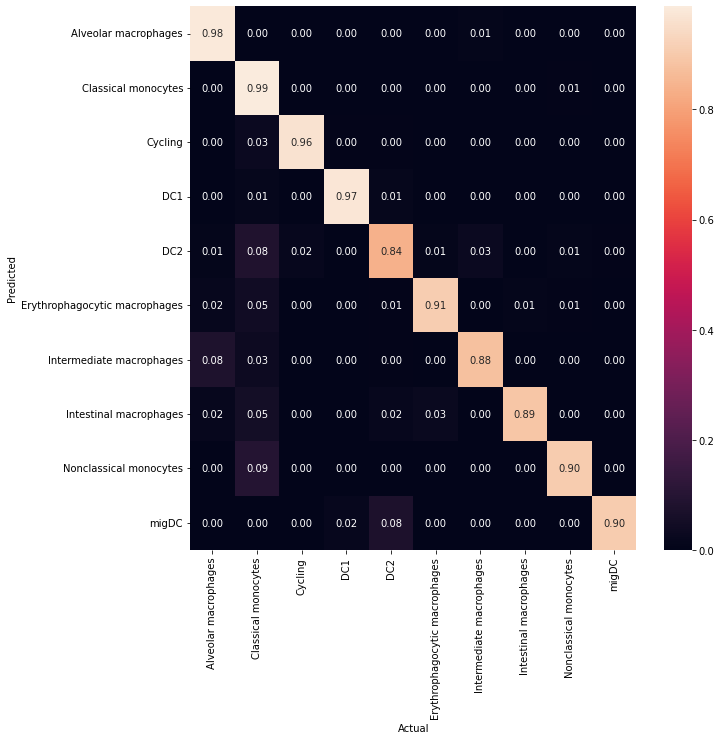

In [9]:
mode='Proto_Net'
loss_mode='disto'
model = train(mode=mode, loss_mode=loss_mode)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 31.39, time 0.7s
Test ER 6.21, time 0.1s
Epoch 2
Train ER 6.01, time 0.6s
Test ER 5.93, time 0.1s
Epoch 3
Train ER 5.65, time 0.6s
Test ER 5.60, time 0.1s
Epoch 4
Train ER 5.22, time 0.6s
Test ER 5.06, time 0.1s
Epoch 5
Train ER 4.78, time 0.6s
Test ER 4.55, time 0.1s
Epoch 6
Train ER 4.54, time 0.7s
Test ER 4.58, time 0.1s
Epoch 7
Train ER 4.32, time 0.6s
Test ER 4.30, time 0.1s
Epoch 8
Train ER 4.18, time 0.6s
Test ER 4.43, time 0.1s
Epoch 9
Train ER 4.10, time 0.6s
Test ER 4.14, time 0.1s
Epoch 10
Train ER 4.01, time 0.6s
Test ER 4.11, time 0.1s
Epoch 11
Train ER 3.96, time 0.6s
Test ER 4.03, time 0.1s
Epoch 12
Train ER 3.97, time 0.6s
Test ER 4.03, time 0.1s
Epoch 13
Train ER 3.88, time 0.6s
Test ER 4.01, time 0.1s
Epoch 14
Train ER 3.87, time 0.6s
Test ER 3.85, time 0.1s
Epoch 15
Train ER 3.82, time 0.6s
Test ER 4.03, time 0.1s
Epoch 16
Train ER 3.79, time 0.6s
Test ER 3.86, time 0.1s
Epoch 17
Train ER 3.74, time 0.6s
Test ER 3.99, time 0.1s
Epoch 18
Train ER 3.73

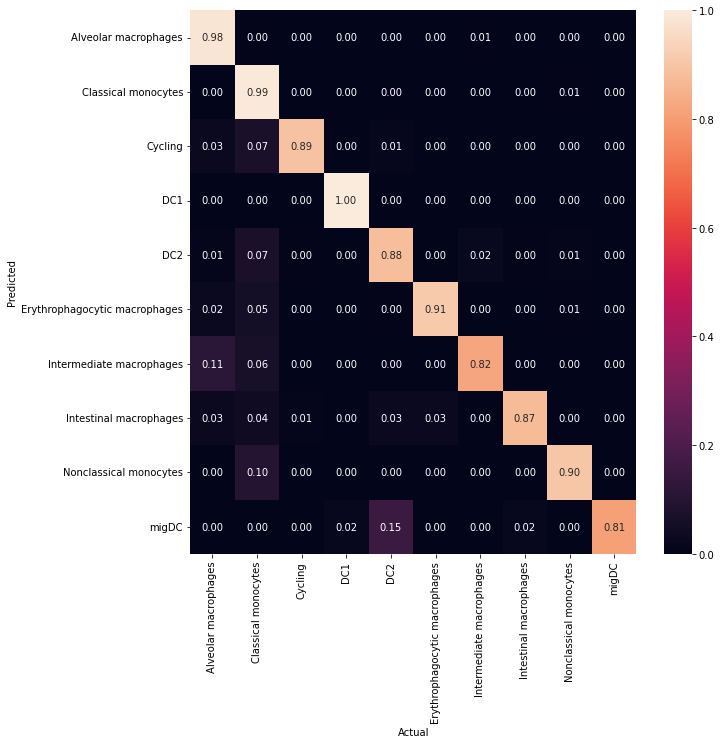

In [10]:
mode='Proto_Net'
loss_mode='disto_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 88.90, time 1.0s
Test ER 72.27, time 0.0s
Epoch 2
Train ER 46.20, time 0.6s
Test ER 25.14, time 0.0s
Epoch 3
Train ER 20.04, time 0.7s
Test ER 18.01, time 0.1s
Epoch 4
Train ER 16.86, time 0.7s
Test ER 16.29, time 0.1s
Epoch 5
Train ER 15.52, time 0.7s
Test ER 14.63, time 0.1s
Epoch 6
Train ER 14.22, time 0.8s
Test ER 13.96, time 0.1s
Epoch 7
Train ER 13.12, time 0.7s
Test ER 13.36, time 0.1s
Epoch 8
Train ER 12.22, time 0.7s
Test ER 11.81, time 0.1s
Epoch 9
Train ER 11.29, time 0.7s
Test ER 11.36, time 0.1s
Epoch 10
Train ER 10.75, time 0.7s
Test ER 10.33, time 0.1s
Epoch 11
Train ER 10.15, time 0.8s
Test ER 9.55, time 0.1s
Epoch 12
Train ER 9.56, time 0.7s
Test ER 9.33, time 0.1s
Epoch 13
Train ER 9.14, time 0.8s
Test ER 9.14, time 0.1s
Epoch 14
Train ER 8.75, time 0.8s
Test ER 8.68, time 0.1s
Epoch 15
Train ER 8.34, time 0.8s
Test ER 8.18, time 0.1s
Epoch 16
Train ER 7.84, time 0.9s
Test ER 8.51, time 0.1s
Epoch 17
Train ER 7.75, time 0.8s
Test ER 7.53, time 0.1s
Ep

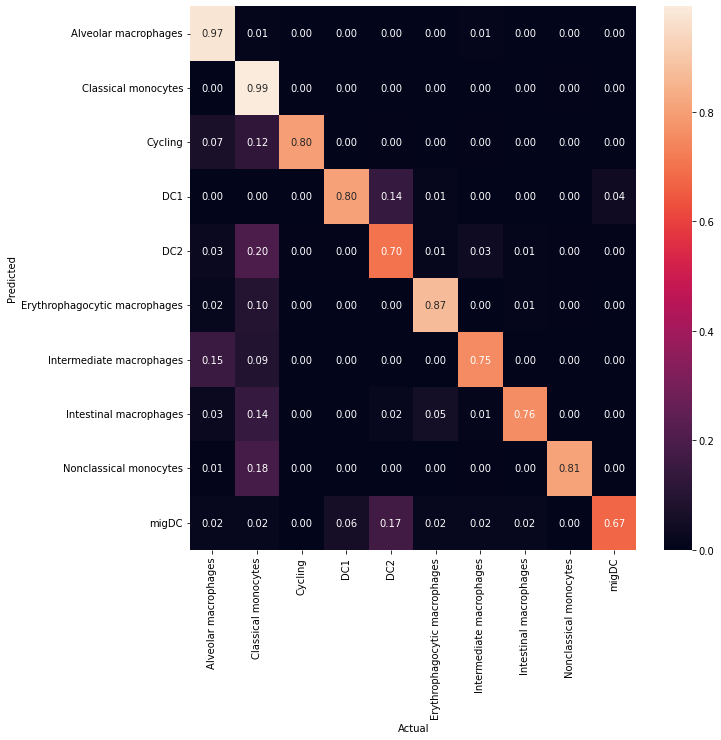

In [14]:
mode='VAE'
loss_mode='vae'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 75.64, time 1.2s
Test ER 59.10, time 0.1s
Epoch 2
Train ER 42.95, time 0.8s
Test ER 28.65, time 0.1s
Epoch 3
Train ER 24.07, time 0.9s
Test ER 21.30, time 0.1s
Epoch 4
Train ER 19.28, time 0.8s
Test ER 18.38, time 0.1s
Epoch 5
Train ER 16.70, time 0.9s
Test ER 15.84, time 0.1s
Epoch 6
Train ER 14.60, time 0.8s
Test ER 14.05, time 0.1s
Epoch 7
Train ER 13.10, time 1.0s
Test ER 12.46, time 0.1s
Epoch 8
Train ER 11.58, time 1.1s
Test ER 11.31, time 0.1s
Epoch 9
Train ER 10.49, time 1.0s
Test ER 10.43, time 0.1s
Epoch 10
Train ER 9.81, time 1.0s
Test ER 9.25, time 0.1s
Epoch 11
Train ER 9.17, time 1.0s
Test ER 8.96, time 0.1s
Epoch 12
Train ER 8.59, time 1.0s
Test ER 8.88, time 0.1s
Epoch 13
Train ER 8.15, time 1.1s
Test ER 8.01, time 0.1s
Epoch 14
Train ER 7.80, time 1.0s
Test ER 7.96, time 0.1s
Epoch 15
Train ER 7.70, time 1.1s
Test ER 7.01, time 0.1s
Epoch 16
Train ER 6.99, time 1.1s
Test ER 6.90, time 0.1s
Epoch 17
Train ER 6.77, time 1.0s
Test ER 6.77, time 0.1s
Epoch

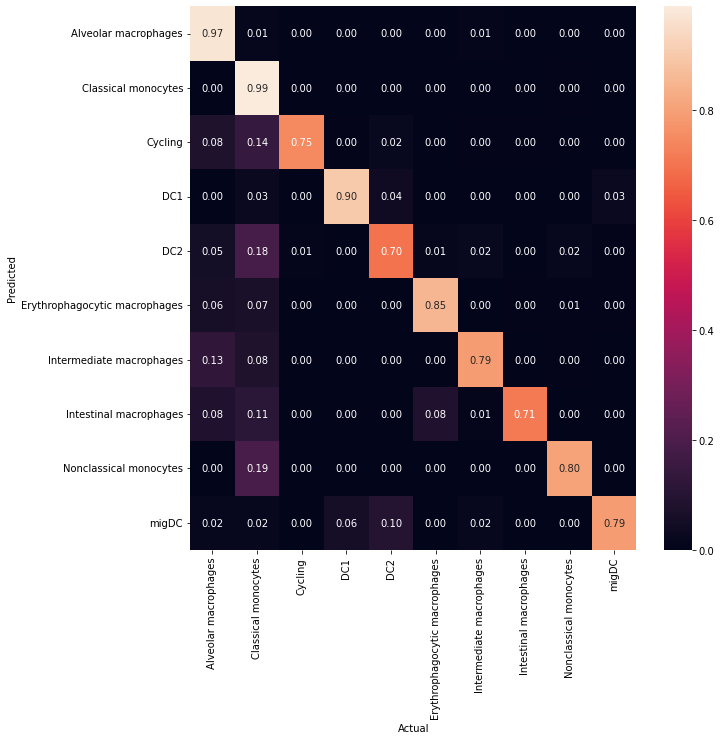

In [15]:
mode='VAE'
loss_mode='vae_disto'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 37.22, time 0.8s
Test ER 16.84, time 0.1s
Epoch 2
Train ER 13.83, time 0.9s
Test ER 10.66, time 0.1s
Epoch 3
Train ER 9.77, time 0.9s
Test ER 8.73, time 0.1s
Epoch 4
Train ER 8.32, time 0.8s
Test ER 8.57, time 0.1s
Epoch 5
Train ER 7.75, time 0.9s
Test ER 7.69, time 0.1s
Epoch 6
Train ER 7.28, time 0.9s
Test ER 6.84, time 0.1s
Epoch 7
Train ER 6.90, time 0.8s
Test ER 6.87, time 0.1s
Epoch 8
Train ER 6.67, time 0.9s
Test ER 6.85, time 0.1s
Epoch 9
Train ER 6.43, time 0.8s
Test ER 6.40, time 0.1s
Epoch 10
Train ER 6.29, time 0.9s
Test ER 6.43, time 0.1s
Epoch 11
Train ER 6.13, time 0.9s
Test ER 6.25, time 0.1s
Epoch 12
Train ER 6.08, time 0.8s
Test ER 6.10, time 0.1s
Epoch 13
Train ER 6.10, time 0.9s
Test ER 5.89, time 0.1s
Epoch 14
Train ER 6.04, time 0.8s
Test ER 6.03, time 0.1s
Epoch 15
Train ER 6.01, time 0.9s
Test ER 6.07, time 0.1s
Epoch 16
Train ER 5.89, time 0.9s
Test ER 5.79, time 0.1s
Epoch 17
Train ER 5.88, time 0.8s
Test ER 6.09, time 0.1s
Epoch 18
Train ER 5

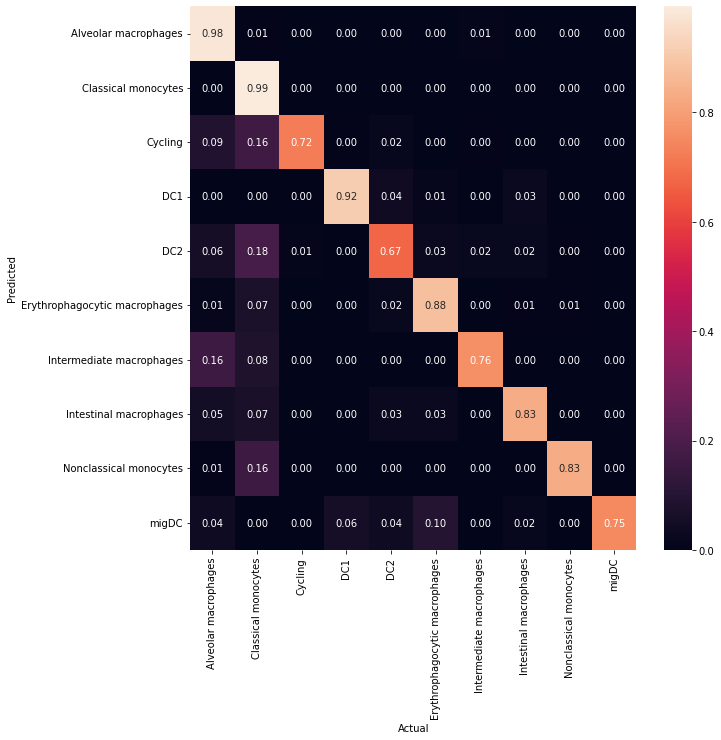

In [16]:
mode='VAE'
loss_mode='vae_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

Epoch 1
Train ER 55.15, time 0.9s
Test ER 20.42, time 0.1s
Epoch 2
Train ER 14.95, time 1.0s
Test ER 12.92, time 0.1s
Epoch 3
Train ER 11.29, time 1.0s
Test ER 9.96, time 0.1s
Epoch 4
Train ER 9.25, time 0.9s
Test ER 8.44, time 0.1s
Epoch 5
Train ER 7.92, time 1.0s
Test ER 7.69, time 0.1s
Epoch 6
Train ER 7.21, time 1.0s
Test ER 6.96, time 0.1s
Epoch 7
Train ER 6.76, time 1.0s
Test ER 6.67, time 0.1s
Epoch 8
Train ER 6.58, time 1.0s
Test ER 6.52, time 0.1s
Epoch 9
Train ER 6.29, time 1.0s
Test ER 6.23, time 0.1s
Epoch 10
Train ER 6.08, time 1.0s
Test ER 5.90, time 0.1s
Epoch 11
Train ER 5.98, time 0.9s
Test ER 5.93, time 0.1s
Epoch 12
Train ER 5.92, time 0.9s
Test ER 6.05, time 0.1s
Epoch 13
Train ER 5.76, time 0.9s
Test ER 5.61, time 0.1s
Epoch 14
Train ER 5.63, time 1.0s
Test ER 5.48, time 0.1s
Epoch 15
Train ER 5.60, time 1.1s
Test ER 5.67, time 0.1s
Epoch 16
Train ER 5.57, time 0.9s
Test ER 5.57, time 0.1s
Epoch 17
Train ER 5.52, time 0.9s
Test ER 5.38, time 0.1s
Epoch 18
Train ER 

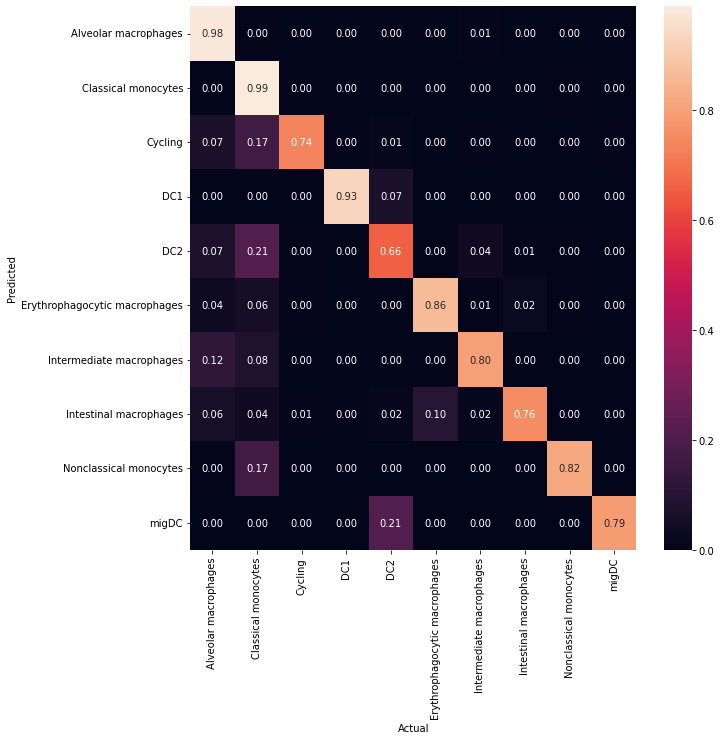

In [17]:
mode='VAE'
loss_mode='vae_disto_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

In [18]:
ids = []
for cell_type in encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))):
    indices = np.where(dataset.obs['Manually_curated_celltype'] == cell_type)[0]
    ids.append(len(indices))

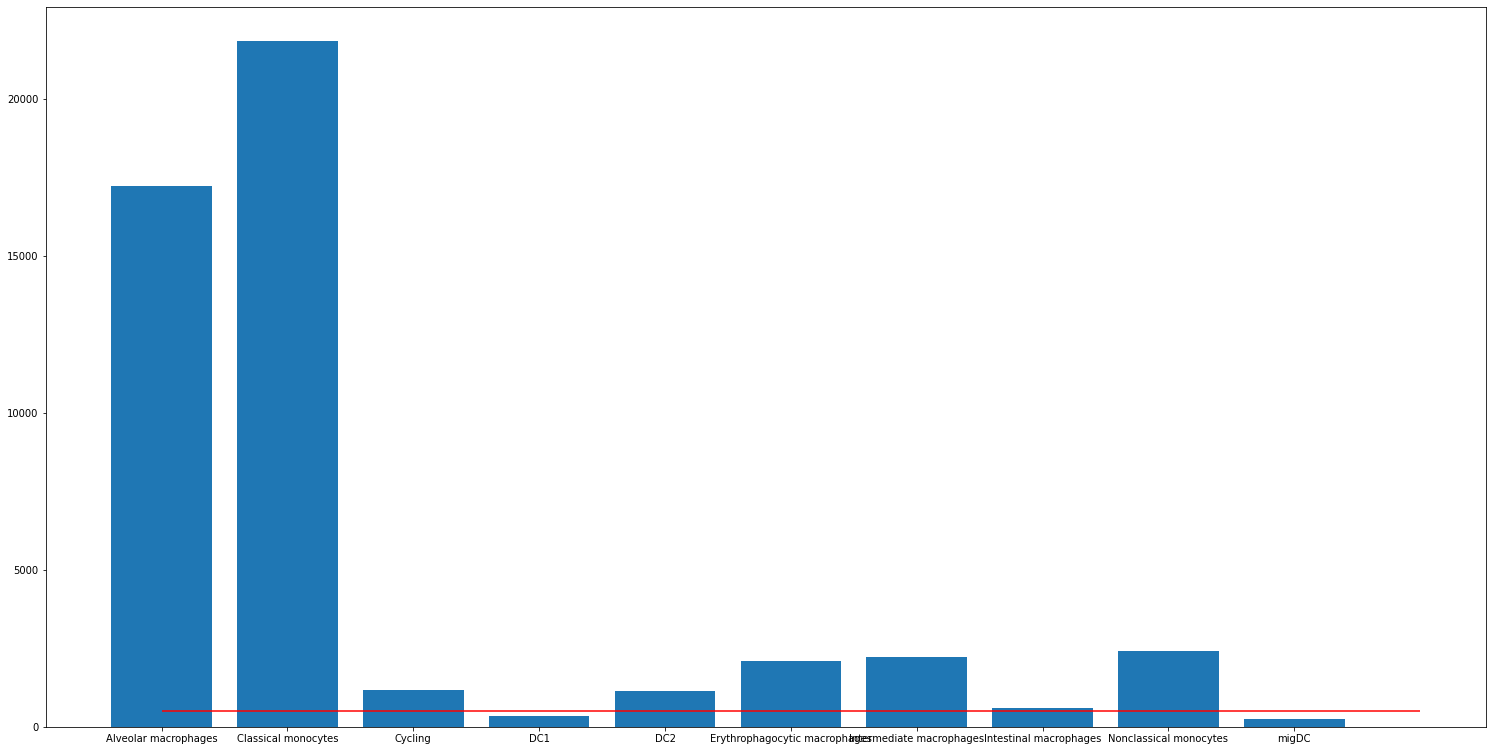

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist())))
students = ids
ax.bar(langs, students)
ax.hlines(500, 0, len(dataset.obs['Manually_curated_celltype'].unique().tolist()), color='r')
fig.set_size_inches(20,10)
plt.show()